# Cross Layer Transcoder Demo on ViT

In [6]:
# imports
import os
import torch
from PIL import Image
import requests
from transformers import AutoImageProcessor, AutoModelForImageClassification
import matplotlib.pyplot as plt
import numpy as np

from utils.CLTModel import CLTModel
from utils.clt import CrossLayerTranscoderSystem, clt_loss, clt_system_loss

### Defining Model 

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


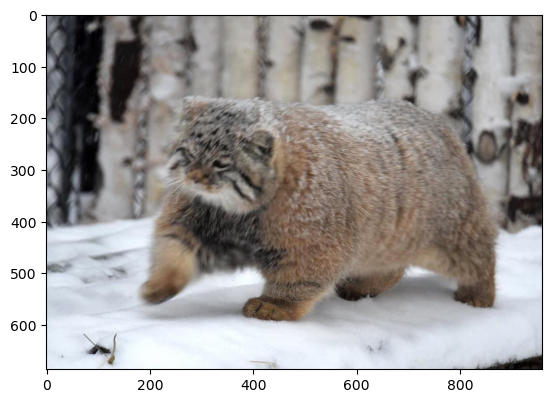

In [7]:
# 1. Define the model checkpoint name
model_checkpoint = "google/vit-base-patch16-224"

image_processor = AutoImageProcessor.from_pretrained(model_checkpoint)
vit = AutoModelForImageClassification.from_pretrained(model_checkpoint)
url = "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/pipeline-cat-chonk.jpeg"
image = Image.open(requests.get(url, stream=True).raw)

plt.imshow(image)

In [8]:
inputs = image_processor(image, return_tensors="pt").to(vit.device)

with torch.no_grad():
  logits = vit(**inputs).logits
predicted_class_id = logits.argmax(dim=-1).item()

class_labels = vit.config.id2label
predicted_class_label = class_labels[predicted_class_id]
print(f"The predicted class label is: {predicted_class_label}")

The predicted class label is: lynx, catamount


## Adding CLT to model

### Single Layer CLT Example

The `CrossLayerTranscoderSystem` creates encoders for each layer and decoders for cross-layer connections.
Here we demonstrate the core components on a small example.

In [9]:
# Wrap your ViT
clt_model = CLTModel(vit)

# listing all CLT layers
clt_model.list_clt_layers()

['vit.encoder.layer.0.intermediate',
 'vit.encoder.layer.1.intermediate',
 'vit.encoder.layer.2.intermediate',
 'vit.encoder.layer.3.intermediate',
 'vit.encoder.layer.4.intermediate',
 'vit.encoder.layer.5.intermediate',
 'vit.encoder.layer.6.intermediate',
 'vit.encoder.layer.7.intermediate',
 'vit.encoder.layer.8.intermediate',
 'vit.encoder.layer.9.intermediate',
 'vit.encoder.layer.10.intermediate',
 'vit.encoder.layer.11.intermediate']

In [10]:
# Create a small CLT system with just 2 layers for demonstration
from utils.clt import CLTEncoder, CLTDecoder

# Get dimensions from the ViT model
hidden_size = vit.config.hidden_size  # 768 for vit-base
intermediate_size = vit.config.intermediate_size  # 3072 for vit-base

# Create encoder and decoder components
encoder = CLTEncoder(input_dim=hidden_size, hidden_dim=4096, k=64)
decoder = CLTDecoder(hidden_dim=4096, output_dim=intermediate_size)

# Forward pass to get activations
with torch.no_grad():
    output = vit(**inputs)

# Create dummy input (simulating residual stream at a layer)
dummy_input = torch.randn(1, 197, hidden_size)  # (batch, seq_len, hidden_dim)

# Encode to sparse features using JumpReLU
features, topk_indices = encoder(dummy_input)
print(f"Input shape: {dummy_input.shape}")
print(f"Features shape: {features.shape}")
print(f"Active features per position: {(features > 0).sum(dim=-1).float().mean().item():.1f}")

# Decode back
reconstructed = decoder(features)
print(f"Reconstructed shape: {reconstructed.shape}")

Input shape: torch.Size([1, 197, 768])
Features shape: torch.Size([1, 197, 4096])
Active features per position: 64.0
Reconstructed shape: torch.Size([1, 197, 3072])


In [11]:
# Demonstrate the loss function with decoder norm weighting
dummy_target = torch.randn(1, 197, intermediate_size)
decoder_norms = decoder.get_feature_norms()

loss, loss_dict = clt_loss(
    output=reconstructed,
    target=dummy_target,
    features=features,
    decoder_norms=decoder_norms,  # Weight sparsity by decoder norms
    l1_coef=1e-3,
    sparsity_c=1.0
)

print("Loss components:")
for k, v in loss_dict.items():
    print(f"  {k}: {v.item():.4f}")

Loss components:
  reconstruction: 1.2014
  sparsity: 0.0155
  total: 1.2015


## Full Cross-Layer Transcoder System

In [12]:
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from torchvision import transforms
from pathlib import Path
from PIL import Image

class ImageFolderDataset(Dataset):
    """Simple dataset for ImageNet-style folder structure."""
    
    def __init__(self, root_dir: str, processor):
        self.root_dir = Path(root_dir)
        self.processor = processor
        
        # Collect all image paths
        self.image_paths = []
        for ext in ['*.jpg', '*.jpeg', '*.JPEG', '*.png']:
            self.image_paths.extend(self.root_dir.rglob(ext))
        
        # tmp
        self.image_paths = self.image_paths[:150]

        print(f"Found {len(self.image_paths)} images in {root_dir}")
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        
        # Process image using the ViT processor
        inputs = self.processor(image, return_tensors="pt")
        
        # Remove batch dimension (DataLoader will add it back)
        return inputs['pixel_values'].squeeze(0)


# Create datasets for train and val, then merge
train_dataset = ImageFolderDataset("data/train", image_processor)
val_dataset = ImageFolderDataset("data/val", image_processor)

# Merge into single dataset
full_dataset = ConcatDataset([train_dataset, val_dataset])
print(f"Total dataset size: {len(full_dataset)}")

# Create dataloader
dataloader = DataLoader(full_dataset, batch_size=8, shuffle=True, num_workers=0)

Found 150 images in data/train
Found 150 images in data/val
Total dataset size: 300


In [13]:
# Path to save/load checkpoint - set to None to train fresh, or a path to load existing
checkpoint_path = "outputs/clt_checkpoint.pt"  # e.g., "outputs/clt_checkpoint.pt" or None

# Wrap your model in the CLT Class
clt_model = CLTModel(vit)

if checkpoint_path and os.path.exists(checkpoint_path):
    # Load existing checkpoint
    result = clt_model.load_clts(checkpoint_path)
    print(f"Loaded checkpoint from {checkpoint_path}")
else:
    # Train fresh - creates the full cross-layer system
    # For L layers, this creates:
    #   - L encoders (one per layer)
    #   - L(L+1)/2 decoders (cross-layer connections)
    clt_model.add_clt_system(hidden_dim=128, k=4)
    
    # Train with the paper's loss formulation:
    # L = L_MSE + λ * Σ tanh(c * ||W_dec,i|| * a_i)
    loss_history = clt_model.train_clts(
        dataloader, 
        num_epochs=1,
        l1_coef=1e-3,      # λ sparsity coefficient
        sparsity_c=1.0     # c hyperparameter in tanh
    )

    # Analyze and save
    result = clt_model.analyze_layer_activations(dataloader)
    if checkpoint_path:
        clt_model.save_clts(checkpoint_path, result=result)

Found 12 MLP layers for CLT system
ADDING Cross Layer Transcoder System
  Layer 0: vit.encoder.layer.0.intermediate
  Layer 1: vit.encoder.layer.1.intermediate
  Layer 2: vit.encoder.layer.2.intermediate
  Layer 3: vit.encoder.layer.3.intermediate
  Layer 4: vit.encoder.layer.4.intermediate
  Layer 5: vit.encoder.layer.5.intermediate
  Layer 6: vit.encoder.layer.6.intermediate
  Layer 7: vit.encoder.layer.7.intermediate
  Layer 8: vit.encoder.layer.8.intermediate
  Layer 9: vit.encoder.layer.9.intermediate
  Layer 10: vit.encoder.layer.10.intermediate
  Layer 11: vit.encoder.layer.11.intermediate

Architecture:
  - 12 encoders (one per layer)
  - 78 decoders (cross-layer connections)
  - Hidden dim: 128, Top-k: 4

Freezing base model's weights for CLT training
Set Optimizer for CLT parameters. Total number of CLT params: 31890432
Training on cpu

Training CLT System



Epoch 1/1: 100%|██████████| 38/38 [00:52<00:00,  1.37s/it, loss=1.026422]


Training complete!
Processed 10 batches
Processed 20 batches
Processed 30 batches
Analyzed 300 samples across 12 layers
Saved CLT checkpoint to outputs/clt_checkpoint.pt


Saved figure to outputs/activations.png


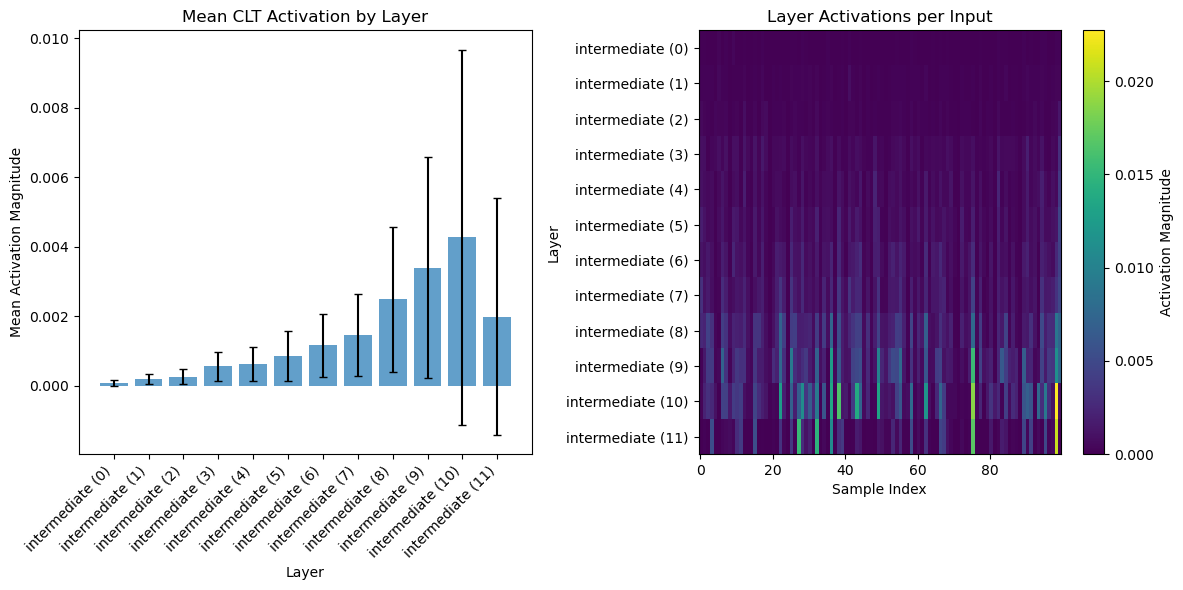

In [14]:
# Plot the activation histogram (result already loaded or computed above)
if result is None:
    result = clt_model.plot_layer_activation_histogram(dataloader, "outputs/activations.png")
else:
    # Just plot using existing result - no reprocessing needed
    clt_model.plot_layer_activation_histogram(output_path="outputs/activations.png", result=result)

peak_layers = result['peak_layers']

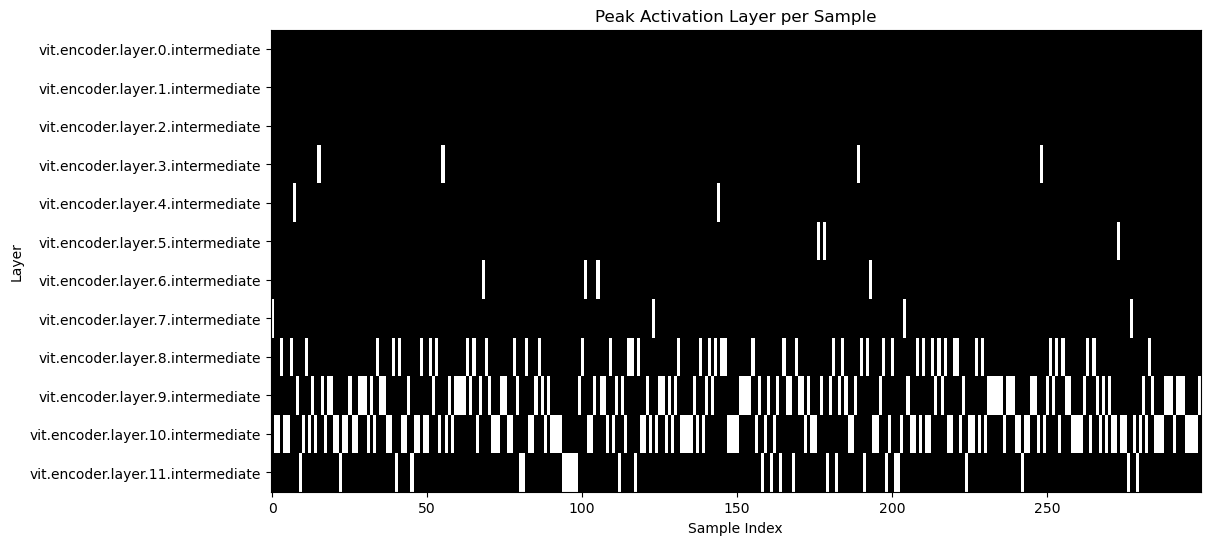

In [15]:
num_layers = len(result['layer_names'])
num_samples = len(peak_layers)

peak_mask = np.zeros((num_layers, num_samples))
for sample_idx, layer_idx in enumerate(peak_layers):
    peak_mask[layer_idx, sample_idx] = 1

plt.figure(figsize=(12, 6))
plt.imshow(peak_mask, aspect='auto', cmap='gray', interpolation='nearest')
plt.yticks(range(num_layers), result['layer_names'])
plt.xlabel('Sample Index')
plt.ylabel('Layer')
plt.title('Peak Activation Layer per Sample')
plt.savefig("outputs/max_activations_per_sample.png", dpi=150)
plt.show()